In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
# 1. Load data
def load_data(file_path):
    # Membaca file CSV dengan format yang sesuai
    df = pd.read_csv(file_path)
    
    # Ekstrak fitur dan label
    X = df.iloc[:, :-2]  # Semua kolom kecuali kolom terakhir (label)
    y = df.iloc[:, -1]   # Kolom terakhir adalah label
    
    return X, y

In [3]:
file_path = "./preprocess_data/word2vec_vectors(withlabel).csv" 
print("Loading data...")
X, y = load_data(file_path)
print(f"Data shape: {X.shape}")
    
# Informasi kelas
print("\nDistribusi label original:")
class_counts = y.value_counts()
print(class_counts)
print(f"Rasio label: {class_counts.values[0] / class_counts.values[-1]:.2f}:1")

Loading data...
Data shape: (2053, 100)

Distribusi label original:
label
positif    955
negatif    661
netral     437
Name: count, dtype: int64
Rasio label: 2.19:1


In [4]:
# 2. Split data menjadi training dan testing
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

In [5]:
print("\nSplitting data...")
X_train, X_test, y_train, y_test = split_data(X, y)


Splitting data...


In [6]:
# 3. Train model SVM dengan SMOTE dan hyperparameter tuning
def train_svm_model_with_smote(X_train, y_train):
    # Pipeline dengan SMOTE, scaling, dan SVM
    smote_pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, random_state=42))
    ])
    
    # Parameter grid untuk grid search
    param_grid = {
        'smote__k_neighbors': [5, 10],  # Jumlah tetangga untuk SMOTE
        'svm__C': [0.1, 1, 10],
        'svm__gamma': ['scale', 'auto', 0.1],
        'svm__kernel': ['rbf', 'linear'],
        'svm__class_weight': ['balanced', None]
    }
    
    # Grid search untuk menemukan parameter terbaik
    grid_search = GridSearchCV(
        smote_pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1, n_jobs=-1
    )
    
    print("Memulai grid search untuk SVM dengan SMOTE...")
    # Fit model
    grid_search.fit(X_train, y_train)
    
    # Tampilkan parameter terbaik
    print("Parameter terbaik: ", grid_search.best_params_)
    print(f"Balanced accuracy terbaik dari cross-validation: {grid_search.best_score_:.4f}")
    
    # Return model dengan parameter terbaik
    return grid_search.best_estimator_

In [7]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("\nDistribusi setelah SMOTE:")
resampled_counts = pd.Series(y_resampled).value_counts()
print(resampled_counts)
print(f"Rasio label setelah SMOTE: {resampled_counts.values[0] / resampled_counts.values[-1]:.2f}:1")


Distribusi setelah SMOTE:
label
positif    764
netral     764
negatif    764
Name: count, dtype: int64
Rasio label setelah SMOTE: 1.00:1


In [8]:
# Fungsi untuk menampilkan kurva ROC - binary classification
def plot_roc_curve_binary(y_test, y_proba):
    # Hitung ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Fungsi untuk menampilkan kurva ROC - multiclass
def plot_roc_curve_multiclass(y_test, y_proba):
    n_classes = y_proba.shape[1]
    
    # Binarize the output for plotting
    from sklearn.preprocessing import label_binarize
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    for i in range(n_classes):
        plt.plot(
            fpr[i], 
            tpr[i], 
            lw=2, 
            label=f'Class {classes[i]} (area = {roc_auc[i]:.2f})'
        )
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
# 4. Evaluasi model dengan penambahan ROC-AUC
def evaluate_model(model, X_test, y_test):
    # Prediksi pada data test
    y_pred = model.predict(X_test)
    
    # Hitung probabilitas 
    y_proba = model.predict_proba(X_test)
    
    # Hitung akurasi
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    
    # Hitung ROC-AUC - dengan penanganan multiclass
    n_classes = len(np.unique(y_test))
    
    print(f"Akurasi: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    
    # ROC-AUC hanya jika binary classification atau multiclass dengan proper handling
    if n_classes == 2:
        # Binary classification
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
        print(f"ROC-AUC: {roc_auc:.4f}")
        # Plot ROC Curve untuk binary classification
        plot_roc_curve_binary(y_test, y_proba[:, 1])
    else:
        # Multiclass classification
        try:
            # Gunakan 'ovr' (one-vs-rest) strategy untuk multiclass
            roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
            print(f"ROC-AUC (macro average, one-vs-rest): {roc_auc:.4f}")
            # Plot ROC Curve untuk multiclass
            plot_roc_curve_multiclass(y_test, y_proba)
        except Exception as e:
            print(f"Tidak dapat menghitung ROC-AUC untuk multiclass: {e}")
            roc_auc = None
    
    # Tampilkan classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(np.unique(y_test)), 
                yticklabels=sorted(np.unique(y_test)))
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title('Confusion Matrix - SVM dengan SMOTE')
    plt.show()
    
    return accuracy, y_pred, roc_auc

In [10]:
# 5. Visualisasi distribusi label sebelum dan sesudah SMOTE
def plot_class_distribution(y_train, y_resampled):
    plt.figure(figsize=(12, 5))
    
    # Distribusi sebelum SMOTE
    plt.subplot(1, 2, 1)
    train_counts = pd.Series(y_train).value_counts()
    bars = sns.countplot(x=y_train)
    # Tambahkan label jumlah di atas bar
    for i, count in enumerate(train_counts):
        bars.text(i, count + 5, str(count), ha='center')
    plt.title('Distribusi Kelas Sebelum SMOTE')
    plt.xlabel('Label')
    plt.ylabel('Jumlah')
    
    # Distribusi setelah SMOTE
    plt.subplot(1, 2, 2)
    resampled_counts = pd.Series(y_resampled).value_counts()
    bars = sns.countplot(x=y_resampled)
    # Tambahkan label jumlah di atas bar
    for i, count in enumerate(resampled_counts):
        bars.text(i, count + 5, str(count), ha='center')
    plt.title('Distribusi Kelas Setelah SMOTE')
    plt.xlabel('Label')
    plt.ylabel('Jumlah')
    
    plt.tight_layout()
    plt.show()

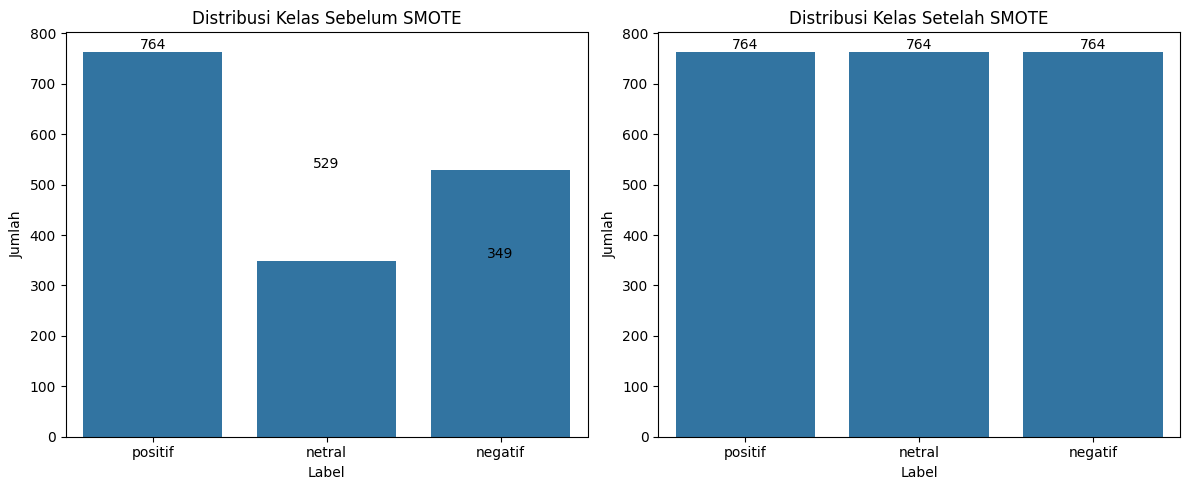

In [11]:
# Visualisasi distribusi sebelum dan sesudah SMOTE
plot_class_distribution(y_train, y_resampled)

In [12]:
# 6. Prediksi sentimen untuk data baru
def predict_sentiment(model, new_data):
    # Prediksi label
    prediction = model.predict(new_data)
    
    # Prediksi probabilitas
    probabilities = model.predict_proba(new_data)
    
    return prediction, probabilities

In [13]:
def compare_models(X_train, X_test, y_train, y_test):
    # Model SVM tanpa SMOTE
    print("\n=== Training SVM TANPA SMOTE ===")
    svm_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, random_state=42, class_weight='balanced'))
    ])
    
    # Fit model tanpa SMOTE
    svm_pipeline.fit(X_train, y_train)
    
    # Evaluasi model tanpa SMOTE
    print("\nEvaluasi SVM TANPA SMOTE:")
    y_pred_no_smote = svm_pipeline.predict(X_test)
    y_proba_no_smote = svm_pipeline.predict_proba(X_test)
    
    # Multiclass metrics
    accuracy_no_smote = accuracy_score(y_test, y_pred_no_smote)
    balanced_acc_no_smote = balanced_accuracy_score(y_test, y_pred_no_smote)
    
    # Safely compute ROC AUC - handle possible errors
    try:
        roc_auc_no_smote = roc_auc_score(y_test, y_proba_no_smote, multi_class='ovr', average='macro')
    except ValueError:
        print("Warning: ROC AUC calculation failed. Using accuracy as a fallback.")
        roc_auc_no_smote = accuracy_no_smote
    
    print(f"Akurasi: {accuracy_no_smote:.4f}")
    print(f"Balanced Accuracy: {balanced_acc_no_smote:.4f}")
    print(f"ROC-AUC: {roc_auc_no_smote:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_no_smote))
    
    # Model SVM dengan SMOTE (sederhana, tanpa grid search)
    print("\n=== Training SVM DENGAN SMOTE (Versi Sederhana) ===")
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    svm_smote_pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True, random_state=42))
    ])
    
    # Fit model dengan SMOTE
    svm_smote_pipeline.fit(X_train_smote, y_train_smote)
    
    # Evaluasi model dengan SMOTE
    print("\nEvaluasi SVM DENGAN SMOTE:")
    y_pred_smote = svm_smote_pipeline.predict(X_test)
    y_proba_smote = svm_smote_pipeline.predict_proba(X_test)
    
    # Multiclass metrics
    accuracy_smote = accuracy_score(y_test, y_pred_smote)
    balanced_acc_smote = balanced_accuracy_score(y_test, y_pred_smote)
    
    # Safely compute ROC AUC - handle possible errors
    try:
        roc_auc_smote = roc_auc_score(y_test, y_proba_smote, multi_class='ovr', average='macro')
    except ValueError:
        print("Warning: ROC AUC calculation failed. Using accuracy as a fallback.")
        roc_auc_smote = accuracy_smote
    
    print(f"Akurasi: {accuracy_smote:.4f}")
    print(f"Balanced Accuracy: {balanced_acc_smote:.4f}")
    print(f"ROC-AUC: {roc_auc_smote:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_smote))
    
    # Plot perbandingan
    labels = ['SVM Tanpa SMOTE', 'SVM Dengan SMOTE']
    accuracies = [accuracy_no_smote, accuracy_smote]
    balanced_accs = [balanced_acc_no_smote, balanced_acc_smote]
    roc_aucs = [roc_auc_no_smote, roc_auc_smote]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.bar(labels, accuracies, color=['blue', 'green'])
    plt.ylim(0, 1)
    plt.title('Perbandingan Akurasi')
    plt.ylabel('Akurasi')
    
    plt.subplot(1, 3, 2)
    plt.bar(labels, balanced_accs, color=['blue', 'green'])
    plt.ylim(0, 1)
    plt.title('Perbandingan Balanced Accuracy')
    plt.ylabel('Balanced Accuracy')
    
    plt.subplot(1, 3, 3)
    plt.bar(labels, roc_aucs, color=['blue', 'green'])
    plt.ylim(0, 1)
    plt.title('Perbandingan ROC-AUC')
    plt.ylabel('ROC-AUC')
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrices untuk kedua model
    plt.figure(figsize=(15, 6))
    
    # Confusion matrix untuk model tanpa SMOTE
    plt.subplot(1, 2, 1)
    cm_no_smote = confusion_matrix(y_test, y_pred_no_smote)
    sns.heatmap(cm_no_smote, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negatif', 'Netral', 'Positif'],
                yticklabels=['Negatif', 'Netral', 'Positif'])
    plt.title('Confusion Matrix - SVM Tanpa SMOTE')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Confusion matrix untuk model dengan SMOTE
    plt.subplot(1, 2, 2)
    cm_smote = confusion_matrix(y_test, y_pred_smote)
    sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Negatif', 'Netral', 'Positif'],
                yticklabels=['Negatif', 'Netral', 'Positif'])
    plt.title('Confusion Matrix - SVM Dengan SMOTE')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.tight_layout()
    plt.show()
    
    # Get unique classes and their indices
    classes = np.unique(y_test)
    n_classes = len(classes)
    class_names = ['Negatif', 'Netral', 'Positif']
    
    # Ensure class_names matches the actual number of classes
    if len(class_names) != n_classes:
        class_names = [f'Class {i}' for i in range(n_classes)]
    
    # Initialize figure for ROC curve
    plt.figure(figsize=(12, 8))
    
    # For each class, compute and plot the ROC curve
    for i, class_idx in enumerate(classes):
        # Check if class exists in both test set and predictions
        if class_idx in np.unique(y_test) and class_idx in np.unique(y_pred_no_smote):
            try:
                # Binarize for current class (one-vs-rest)
                y_test_bin = (np.array(y_test) == class_idx).astype(int)
                
                # No SMOTE
                if i < y_proba_no_smote.shape[1]:  # Check if class index is valid
                    try:
                        fpr, tpr, _ = roc_curve(y_test_bin, y_proba_no_smote[:, i])
                        roc_auc = auc(fpr, tpr)
                        if not np.isnan(roc_auc):  # Only plot if AUC is valid
                            plt.plot(fpr, tpr, lw=2, 
                                    label=f'{class_names[i]} - No SMOTE (AUC = {roc_auc:.4f})')
                    except Exception as e:
                        print(f"Error calculating ROC for class {class_names[i]} without SMOTE: {e}")
                
                # With SMOTE
                if i < y_proba_smote.shape[1]:  # Check if class index is valid
                    try:
                        fpr, tpr, _ = roc_curve(y_test_bin, y_proba_smote[:, i])
                        roc_auc = auc(fpr, tpr)
                        if not np.isnan(roc_auc):  # Only plot if AUC is valid
                            plt.plot(fpr, tpr, lw=2, linestyle='--',
                                    label=f'{class_names[i]} - With SMOTE (AUC = {roc_auc:.4f})')
                    except Exception as e:
                        print(f"Error calculating ROC for class {class_names[i]} with SMOTE: {e}")
            except Exception as e:
                print(f"Could not process class {class_idx}: {e}")
    
    # Plot the diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    
    return {
        'no_smote': {'accuracy': accuracy_no_smote, 'balanced_acc': balanced_acc_no_smote, 'roc_auc': roc_auc_no_smote},
        'smote': {'accuracy': accuracy_smote, 'balanced_acc': balanced_acc_smote, 'roc_auc': roc_auc_smote}
    }


Membandingkan model SVM dengan dan tanpa SMOTE...

=== Training SVM TANPA SMOTE ===

Evaluasi SVM TANPA SMOTE:
Akurasi: 0.5499
Balanced Accuracy: 0.5672
ROC-AUC: 0.7538

Classification Report:
              precision    recall  f1-score   support

     negatif       0.56      0.67      0.61       132
      netral       0.41      0.58      0.48        88
     positif       0.67      0.46      0.54       191

    accuracy                           0.55       411
   macro avg       0.55      0.57      0.54       411
weighted avg       0.58      0.55      0.55       411


=== Training SVM DENGAN SMOTE (Versi Sederhana) ===

Evaluasi SVM DENGAN SMOTE:
Akurasi: 0.5474
Balanced Accuracy: 0.5606
ROC-AUC: 0.7444

Classification Report:
              precision    recall  f1-score   support

     negatif       0.55      0.66      0.60       132
      netral       0.40      0.56      0.47        88
     positif       0.67      0.47      0.55       191

    accuracy                           0.55 

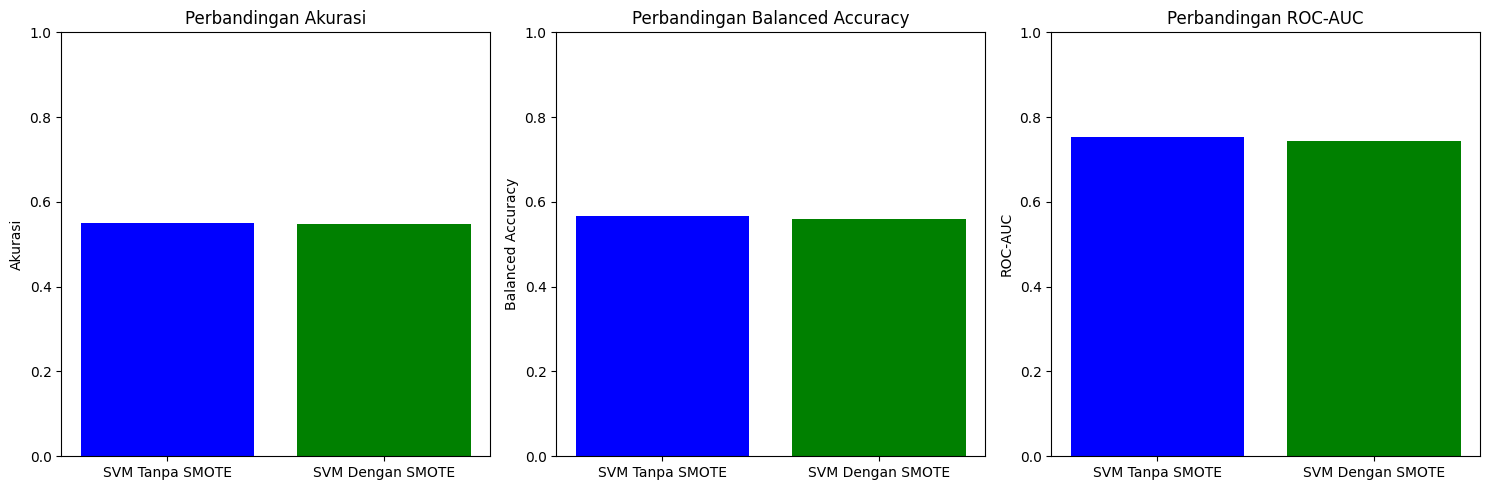

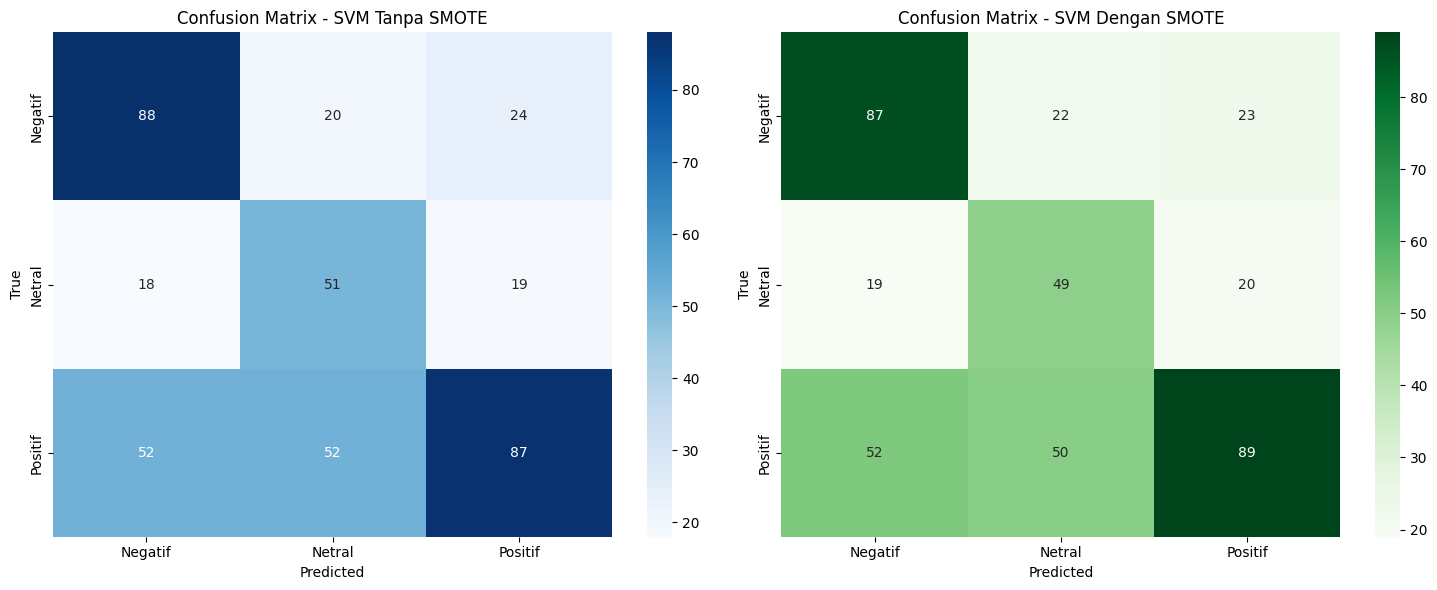

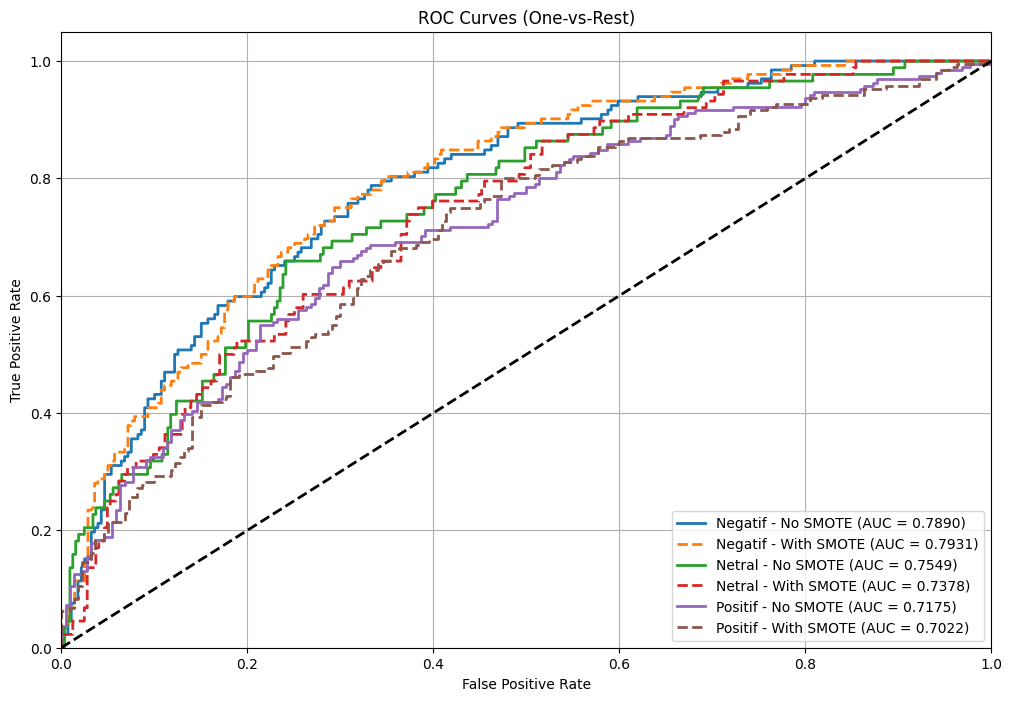


Training SVM model dengan SMOTE dan Grid Search...
Memulai grid search untuk SVM dengan SMOTE...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

In [14]:
# Perbandingan model dengan dan tanpa SMOTE (opsional)
print("\nMembandingkan model SVM dengan dan tanpa SMOTE...")
results = compare_models(X_train, X_test, y_train, y_test)
    
# Train model SVM dengan SMOTE dan hyperparameter tuning
print("\nTraining SVM model dengan SMOTE dan Grid Search...")
model = train_svm_model_with_smote(X_train, y_train)
    
# Evaluasi model final
print("\nEvaluasi model final pada data test:")
evaluate_model(model, X_test, y_test)
    
    # Simpan model (opsional)
    # from joblib import dump
    # dump(model, 'sentiment_svm_smote_model.joblib')